## Initialize and inspect the Dask client

In [3]:
#click on <> button in Dask plugin and run the cell. You should obtain a cell like the next one

In [4]:
from dask.distributed import Client

client = Client("localhost:30445")
client

/opt/conda/lib/python3.9/site-packages/distributed/client.py:1123: VersionMismatchWarning: Mismatched versions found

+-------------+-----------+-----------+---------+
| Package     | client    | scheduler | workers |
+-------------+-----------+-----------+---------+
| dask        | 2021.09.1 | 2021.09.0 | None    |
| distributed | 2021.09.1 | 2021.09.0 | None    |
+-------------+-----------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Connection method: Direct,
Dashboard: http://localhost:39434/status,
Comm: tcp://10.244.3.95:30445,Workers: 0
Dashboard: http://10.244.3.95:39434/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Inspect the Dask cluster

## Declare your custom functions inside an initialization function
This function is used to initialize each worker process. This is necessary since ```ROOT.gInterpreter.Declare()``` has effect only on the local C++ interpreter. Here you should declare all custom functions that you plan to use in the analysis. In this example, a ```CountGoodMuons(const RVec<float> &pt)``` function is defined that will be used for a ```Define``` of a new column of the DataFrame.

In [5]:
import ROOT

def my_initialization_function():
  ROOT.gInterpreter.Declare("""
  #include "ROOT/RVec.hxx"
  using namespace ROOT::VecOps;
  
  size_t CountGoodMuons(const RVec<float> &pt){
    size_t n = 0;
    for (size_t i = 0; i < pt.size(); i++) {
        if (pt[i] > 50) n++;
    }
    return n;
  }
  """)

#### you can also declare functions inside a myfunctions.h file like this: #####
# text_file = open("myfunctions.h", "r")
# data = text_file.read()
# def my_initialization_function():
#    ROOT.gInterpreter.Declare('{}'.format(data))

ROOT.RDF.Experimental.Distributed.initialize(my_initialization_function)

Error in <TExMap::Add>: key 140713210379744 is not unique
Error in <TExMap::Add>: key 140713210896336 is not unique
TClassTable::Add:0: RuntimeWarning: class timespec already in TClassTable
TClassTable::Add:0: RuntimeWarning: class reverse_iterator<__gnu_cxx::__normal_iterator<TString*,vector<TString> > > already in TClassTable
TClassTable::Add:0: RuntimeWarning: class reverse_iterator<__gnu_cxx::__normal_iterator<int*,vector<int> > > already in TClassTable
TClassTable::Add:0: RuntimeWarning: class reverse_iterator<__gnu_cxx::__normal_iterator<string*,vector<string> > > already in TClassTable
TClassTable::Add:0: RuntimeWarning: class __gnu_cxx::__normal_iterator<char*,string> already in TClassTable
TClassTable::Add:0: RuntimeWarning: class __gnu_cxx::__normal_iterator<const char*,string> already in TClassTable
TClassTable::Add:0: RuntimeWarning: class __gnu_cxx::__normal_iterator<TString*,vector<TString> > already in TClassTable
TClassTable::Add:0: RuntimeWarning: class __gnu_cxx::__no

Welcome to JupyROOT 6.25/01


## Create DataFrame and book actions and transformations - no custom functions
Here is an example of how to use ```Define``` and ```Filter``` using simple simple algebraic expressions: create a new column, ```nLightLepton```, which contains the sum of ```nMuon``` and ```nElectron``` in the event and keep events in which ```nLightLepton``` is greater or equal to 5

In [6]:
import ROOT 
 
# Create dataframe from NanoAOD files
df = ROOT.RDF.Experimental.Distributed.Dask.RDataFrame("Events", "https://ttedesch.web.cern.ch/ttedesch/cms_opendata_2012_nanoaod_skimmed/Run2012C_DoubleMuParked.root", npartitions=1, daskclient=client)
df_defined = df.Define("nLightLepton", "nMuon + nElectron")
df_filtered = df_defined.Filter("nLightLepton >= 5", "Filter events with at least 5 light leptons")
h = df_filtered.Histo1D(("nLightLepton","nLightLepton; nLightLepton ;N_{Events}",10,0,10),"nLightLepton")

## Draw histo (the event loop is triggered here)
A simple histogram of the newly-defined variable

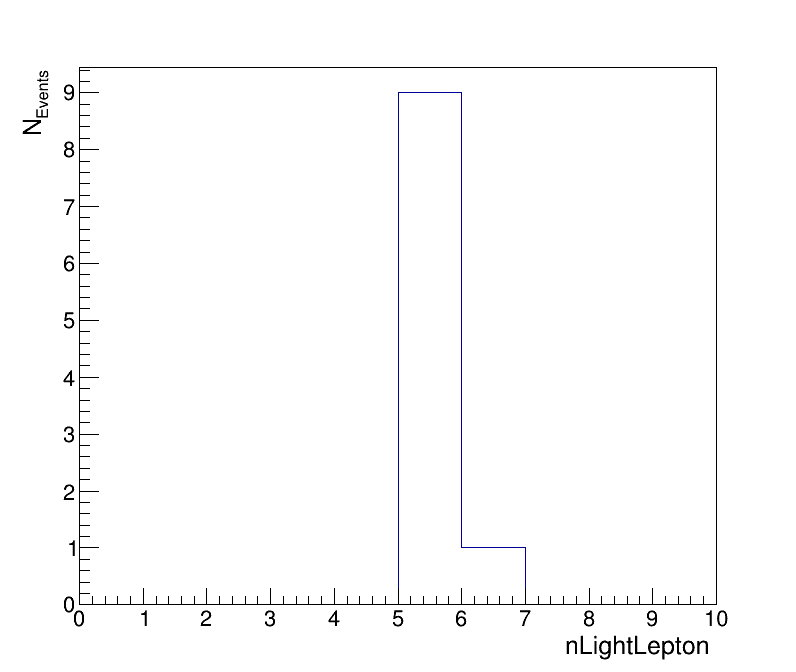

In [7]:
ROOT.gStyle.SetOptStat(0); ROOT.gStyle.SetTextFont(42)
c = ROOT.TCanvas("c", "", 800, 700)
h.SetTitle("")
h.GetXaxis().SetTitleSize(0.04)
h.GetYaxis().SetTitleSize(0.04)
h.Draw()
c.Draw()

## Create DataFrame and book actions and transformations - use custom function defined in my_initialization_function()
Here the ```Define``` action uses the ```CountGoodMuons(Muon_pt)``` function (declared to the C++ interpreter in ```my_initialization_function()```) which loops over all Muon pts in the event and counts how many muons have a pt greater than 50 GeV. Then a simple ```Filter``` action is booked: only events with at least one muon with pt greater than 50 GeV are kept. 

In [8]:
import ROOT 
 
# Create dataframe from NanoAOD files
df = ROOT.RDF.Experimental.Distributed.Dask.RDataFrame("Events", "https://ttedesch.web.cern.ch/ttedesch/cms_opendata_2012_nanoaod_skimmed/Run2012C_DoubleMuParked.root", npartitions=1, daskclient=client)
df_defined = df.Define("nMuons_over50", "CountGoodMuons(Muon_pt)")
df_filtered = df_defined.Filter("nMuons_over50 > 0", "Filter events with at least 1 muon with pt>50 GeV")
h = df_filtered.Histo1D(("nMuons_over50","nMuons_over50; nMuons_over50 ;N_{Events}",5,0,5),"nMuons_over50")

## Draw histo (the event loop is triggered here)
A simple histogram of the newly-defined variable.

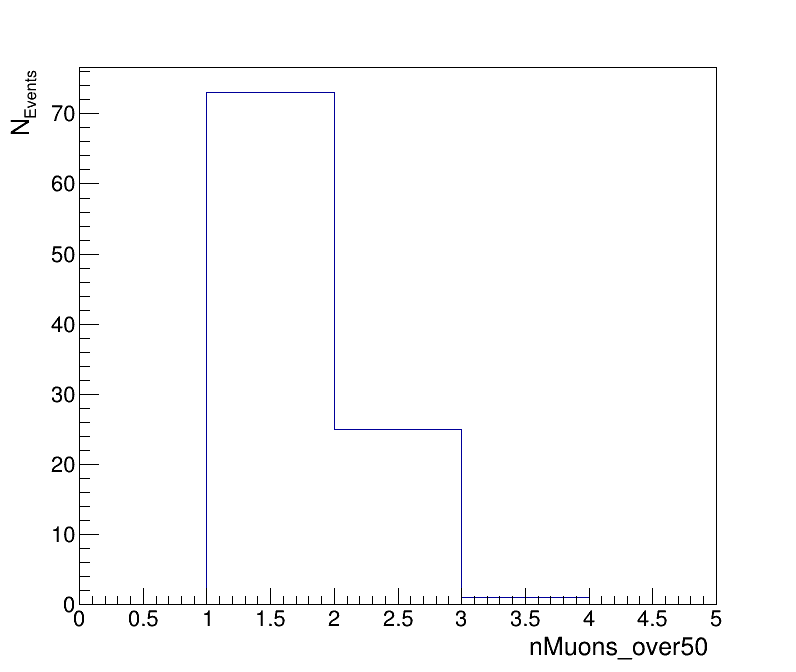

In [9]:
ROOT.gStyle.SetOptStat(0); ROOT.gStyle.SetTextFont(42)
c1 = ROOT.TCanvas("c1", "", 800, 700)
h.SetTitle("")
h.GetXaxis().SetTitleSize(0.04)
h.GetYaxis().SetTitleSize(0.04)
h.Draw()
c1.Draw()